**Animal Performance on W-Track** 

**Set up**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import re
from sys import argv
import matplotlib.pyplot as pyplot

In [ ]:
#base_name = '20230531_154845' #'20230531_150338'
#data_directory = f'/home/zoldello/Documents/data/L5/r2/{base_name}/'

base_name = '20230531_150338'
data_directory = f'/home/phil/Documents/Data/L5/r1/20230531_150338'
dio_directory = f'{base_name}.DIO'
time_directory = f'{base_name}.time'
# trodes_directory = '/home/zoldello/Apps/Trodes_2-4-0_Ubuntu2004/'
trodes_directory =  ' /home/phil/Apps/Trodes_2-4-0_Ubuntu2004/'
dio_path = f'{data_directory}/{dio_directory}/{base_name}'

file_name = f'{data_directory}/{base_name}.rec'
trodesexport_runner = f'{trodes_directory}trodesexport'

In [ ]:
!$trodesexport_runner -rec {file_name} -dio -time
#!/home/zoldello/Apps/Trodes_2-4-0_Ubuntu2004/trodesexport -rec {file_name} -dio -time

**Trodes' Functions**

In [ ]:
# Main function
def readTrodesExtractedDataFile(filename):
    with open(filename, 'rb') as f:
        # Check if first line is start of settings block
        if f.readline().decode('ascii').strip() != '<Start settings>':
            raise Exception("Settings format not supported")
        fields = True
        fieldsText = {}
        for line in f:
            # Read through block of settings
            if(fields):
                line = line.decode('ascii').strip()
                # filling in fields dict
                if line != '<End settings>':
                    vals = line.split(': ')
                    fieldsText.update({vals[0].lower(): vals[1]})
                # End of settings block, signal end of fields
                else:
                    fields = False
                    dt = parseFields(fieldsText['fields'])
                    fieldsText['data'] = np.zeros([1], dtype = dt)
                    break
        # Reads rest of file at once, using dtype format generated by parseFields()
        dt = parseFields(fieldsText['fields'])
        data = np.fromfile(f, dt)
        fieldsText.update({'data': data})
        return fieldsText


# Parses last fields parameter (<time uint32><...>) as a single string
# Assumes it is formatted as <name number * type> or <name type>
# Returns: np.dtype
def parseFields(fieldstr):
    # Returns np.dtype from field string
    sep = re.split('\s', re.sub(r"\>\<|\>|\<", ' ', fieldstr).strip())
    # print(sep)
    typearr = []
    # Every two elmts is fieldname followed by datatype
    for i in range(0,sep.__len__(), 2):
        fieldname = sep[i]
        repeats = 1
        ftype = 'uint32'
        # Finds if a <num>* is included in datatype
        if sep[i+1].__contains__('*'):
            temptypes = re.split('\*', sep[i+1])
            # Results in the correct assignment, whether str is num*dtype or dtype*num
            ftype = temptypes[temptypes[0].isdigit()]
            repeats = int(temptypes[temptypes[1].isdigit()])
        else:
            ftype = sep[i+1]
        try:
            fieldtype = getattr(np, ftype)
        except AttributeError:
            print(ftype + " is not a valid field type.\n")
            exit(1)
        else:
            typearr.append((str(fieldname), fieldtype, repeats))
    return np.dtype(typearr)

**Time**

In [ ]:
times = readTrodesExtractedDataFile(f'{data_directory}/{time_directory}/{base_name}.timestamps.dat')
time_data = times['data']
#time = readTrodesExtractedDataFile(f'/stelmo/kyu/L5/20230502/r2/20230502_163824/20230502_163824.time/20230502_163824.timestamps.dat')

**Functions**

In [ ]:
def map_trodes_time_to_ptp(time_data: None):
    trodes_and_ptp_map = {}
    for time_datum in time_data:
        trodes_and_ptp_map[time_datum[0]] = time_datum[1]
    return trodes_and_ptp_map

In [ ]:
def convert_trodes_time_to_ptp(trodes_times: None, trodes_time_key_to_ptp: None):
    ptp_times = []
    for trodes_time in trodes_times:
        ptp_times.append(trodes_time_key_to_ptp.get(trodes_time, 0))
    return ptp_times

In [ ]:
def split_time_and_data_values(data: None):
    x = []
    y = []
    for datum in data:
        x.append(datum[0])
        y.append(datum[1])
    return x, y

**Dins**

In [ ]:
din1 = readTrodesExtractedDataFile(f'{dio_path}.dio_ECU_Din1.dat')
din2 = readTrodesExtractedDataFile(f'{dio_path}.dio_ECU_Din2.dat')
din7 = readTrodesExtractedDataFile(f'{dio_path}.dio_ECU_Din7.dat')

**Dout**

In [ ]:
dout4 = readTrodesExtractedDataFile(f'{dio_path}.dio_ECU_Dout4.dat')
dout5 = readTrodesExtractedDataFile(f'{dio_path}.dio_ECU_Dout5.dat')
dout6 = readTrodesExtractedDataFile(f'{dio_path}.dio_ECU_Dout6.dat')

**Time Map**

In [ ]:
trodes_key_to_ptp = map_trodes_time_to_ptp(time_data)

**Conversions**

In [ ]:
def convert_ptp_to_seconds_starting_at_first_time(time_values, time0):
    return [ round(((t - time0)/1000000000), 3) for t in time_values]

**Data Values**

In [ ]:
time0 = time_data[0][1]

din1_split = split_time_and_data_values(din1['data'])
din1_time = convert_ptp_to_seconds_starting_at_first_time(
    convert_trodes_time_to_ptp(din1_split[0], trodes_key_to_ptp), time0
)
din1_dio =  din1_split[1]

din2_split = split_time_and_data_values(din2['data'])
din2_time = convert_ptp_to_seconds_starting_at_first_time(
    convert_trodes_time_to_ptp(din2_split[0], trodes_key_to_ptp), time0
)
din2_dio =  din2_split[1]

din7_split = split_time_and_data_values(din7['data'])
din7_time = convert_ptp_to_seconds_starting_at_first_time(
    convert_trodes_time_to_ptp(din7_split[0], trodes_key_to_ptp), time0
)
din7_dio =  din1_split[1]

In [ ]:
time0 = time_data[0][1]

dout4_split = split_time_and_data_values(dout4['data'])
dout4_time = convert_ptp_to_seconds_starting_at_first_time(
    convert_trodes_time_to_ptp(dout4_split[0], trodes_key_to_ptp), time0
)
dout4_dio =  dout4_split[1]

dout5_split = split_time_and_data_values(dout5['data'])
dout5_time = convert_ptp_to_seconds_starting_at_first_time(
    convert_trodes_time_to_ptp(dout5_split[0], trodes_key_to_ptp), time0
)
dout5_dio =  dout5_split[1]

dout6_split = split_time_and_data_values(dout6['data'])
dout6_time = convert_ptp_to_seconds_starting_at_first_time(
    convert_trodes_time_to_ptp(dout6_split[0], trodes_key_to_ptp), time0
)
dout6_dio =  dout6_split[1]

**Markdown**

In [272]:
def map_poke_and_reward(din=None, din_time=None, dout=None, dout_time=None):
    din_length = len(din)
    dout_length = len(dout)
    din_index = 0
    dout_last_index = 0
    leeway = 15
    reward_count = 0
    poke_time = []
    rewarded = []
    approx_trodes_delay = 2#0.500
    previous_din_time = None
    current_din_time = din_time[0]
    
    while din_index < din_length - 1:
        current_din_time = din_time[din_index]
        skip_loop = (
            din_index % 2 == 1 or
            current_din_time == 0.0 or
            previous_din_time is not None and (previous_din_time + leeway) > current_din_time
        )
        
        if skip_loop:
            din_index += 1
            continue

        # print('------')
        # print(din_index)
        # print('------')
            
            
        reward_count = 0
        previous_din_time = current_din_time
        beam_broke_time = current_din_time - approx_trodes_delay
        beam_broke_time_plus_leeway = current_din_time + leeway        
        dout_reward_time = [d for i,d in enumerate(dout_time) if i % 2 == 1]
        
        for dt_index, dt in enumerate(dout_reward_time):
            if beam_broke_time > dt:
                # outside of time range, continue loop
                continue
            if beam_broke_time_plus_leeway < dt:
                # outside of leeway. No need to go further
                break
            reward_count = 1

        poke_time.append(din_time[din_index])
        rewarded.append(1 if reward_count == 1 else 0)
        din_index += 1;

        while din_index < (din_length - 1) and beam_broke_time_plus_leeway > din_time[din_index]:
            # skip over leeway time
            din_index += 1
    return poke_time, rewarded

**Get Info on Poke time and reward**

In [135]:
reward_well_1_poke_time, reward_well_1_rewarded = map_poke_and_reward(din1_dio, din1_time, dout4_dio, dout4_time)
reward_well_2_poke_time, reward_well_2_rewarded = map_poke_and_reward(din2_dio, din2_time, dout5_dio, dout5_time)
reward_well_3_poke_time, reward_well_3_rewarded = map_poke_and_reward(din7_dio, din7_time, dout6_dio, dout6_time)

In [ ]:
##################

In [277]:
map_poke_and_reward(din1_dio, din1_time, dout4_dio, dout4_time)
#map_poke_and_reward(din2_dio, din2_time, dout5_dio, dout5_time)

#map_poke_and_reward(din7_dio, din7_time, dout6_dio, dout6_time)

#[d for i,d in enumerate(din2_time) if i % 2 == 0]
#[d for i,d in enumerate(dout4_time) if i % 2 == 1]#map_poke_and_reward(din7_dio, din7_time, dout6_dio, dout6_time)

#din7_time
#dout4_time
#[d for i,d in enumerate(dout4_time) if i % 2 == 1]
#dout4_time
#din1_dio


#[d for i,d in enumerate(din1_time) if i % 2 == 0]
#[d for i,d in enumerate(dout4_time) if i % 2 == 1]

#[d for i,d in enumerate(din2_time) if i % 2 == 0]
#[d for i,d in enumerate(dout4_time) if i % 2 == 1]

#[d for i,d in enumerate(din7_time) if i % 2 == 0]
[d for i,d in enumerate(dout4_time) if i % 2 == 1]

[91.019,
 186.802,
 268.902,
 353.007,
 449.559,
 541.474,
 621.4,
 731.393,
 827.032,
 911.249,
 997.722,
 1116.175,
 1316.036,
 1395.631,
 1484.347]

In [ ]:
len(dout5_time)

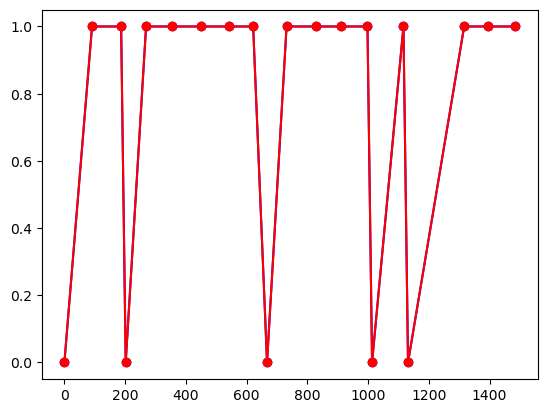

In [117]:
poke_time, rewarded = map_poke_and_reward(din1_dio, din1_time, dout4_dio, dout4_time)


fig, ax = plt.subplots()
ax.plot(poke_time, rewarded, **{'color': 'blue', 'marker': 'o'})


ax.plot(poke_time, rewarded, **{'color': 'red', 'marker': 'o'})




#map_poke_and_reward(din7_dio, din7_time, dout6_dio, dout6_time)

#din1_time

In [ ]:
# dout4_time
din7
# [ v for i,v in enumerate(dout4_time) if i % 2 == 0]
#din7_time
din1_time

In [ ]:
# print(din1['data'])
# print('---')
# print(din2['data'])
# print('---')
# print(din7['data'])

print(din1_time)
print('---')
print(din2_time)
print('---')
print(din7_time)

In [120]:
din1_split[1]

[1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,


In [ ]:
dout4_time_ptp

In [ ]:
convert_ptp_to_seconds_starting_at_first_time(dout4_time_ptp)

In [ ]:
dout4_dio

In [ ]:
[((i - 1685570658686448628)/1000000000) for i in dout4_time_ptp]
#(dout4_time_ptp)
#len(dout4_dio)

In [ ]:
din1_dio[45:50]

In [ ]:
[((i - 1685570658686448628)/1000000000) for i in din1_time_ptp][45:200]
#len(din1_dio)

**Data Expansion**

In [ ]:
def get_accuracy(din, dout):
    din_data = din['data']
    dout_data = dout['data']
    din_data_length = len(din_data)
    dout_data_length = len(dout_data)
    dout_index = 1
    dout_time = dout_data[1][0]
    pump_delay_unit = 1000
    correctness = []
    
    for i in range(0, din_data_length, 2):
        din_time = din_data[i][0] + pump_delay_unit
        current_correctness = 1 if (din_time >= dout_time) else 0
        correctness.append(current_correctness)
        
        if (current_correctness == 1):
            dout_index += 2
            
            if (dout_index == dout_data_length):
                break
            
            dout_time = dout_data[dout_index][0]
    
    return correctness
    

**Get Din Data for Plotting**

In [ ]:
def format_din_for_plotting(din):
    data = din['data']
    data_length = len(data)
    formatted_data = []
    dataX = []
    dataY = []
    dataX0 = data[0][0]
    
    for i in range(data_length):
        data_item = data[i]
        dataX.append((data_item[0]))
        dataY.append(data_item[1])
        
    return dataX, dataY

# def format_din_for_plotting(din):
#     data = din['data']
#     data_length = len(data)
#     timestamp_at_creation = din['timestamp_at_creation']
#     last_time_stamp = data[data_length - 1][0]
#     time_range = last_time_stamp - int(timestamp_at_creation)
#     dataX = [0 for _ in range(time_range)]
#     dataY = [0 for _ in range(time_range)]
    
#     for i in range(data_length):
#         dataY[i] = data[i][1]

#     return dataX, dataY

    

In [ ]:

plt.figure(figsize=(20, 20))
x = format_din_for_plotting(din1)
plt.bar(x[0][0:100], x[1][0:100], color='black', edgecolor='black', linewidth=0.3)
plt.show()

plt.figure(figsize=(20, 20))
y = format_din_for_plotting(dout4)
plt.bar(y[0][0:100], y[1][0:100], color='red', edgecolor='red', linewidth=0.3)
plt.show()

# y = format_din_for_plotting(dout4)
# plt.plot(np.array(y[0]), np.array(y[1]))
# plt.show()


# pop = [22,55,62,45,21,22,34,42,42,4,2,8]
# bins = [1,10,20,30,40,50]
# pyplot.hist(pop, bins, rwidth=0.6)


In [ ]:
##################### function ###########################3
ptp_times = []
def convert_trodes_time_to_ptp(trodes_times: None):
    for trodes_time in trodes_times:
        for ptp_time in time['data']:
            if trodes_time == ptp_time[0]:
                ptp_times.append(ptp_time[1])
                break
    return ptp_times

In [ ]:
din1_x = []
din1_y = []
for data in din1['data']:
    din1_x.append(data[0])
    din1_y.append(data[1])

In [ ]:
dout1_x = []
dout1_y = []
for data in dout4['data']:
    dout1_x.append(data[0])
    dout1_y.append(data[1])

In [ ]:
def test_plot(x,y):
    # x = np.linspace(0,5,10)
    # y = np.array([1,0, 0, 0 , 0, 1, 1, 1,0,1])

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.step(x,y,color='r')
    #ax.step(x,y+2,color='g')
#ax.set_ylim([-2,9])
#ax.set_xlim([-1,6])
    ax.legend()

    ax.draw()

In [ ]:
test_plot(din1_x, din1_y)

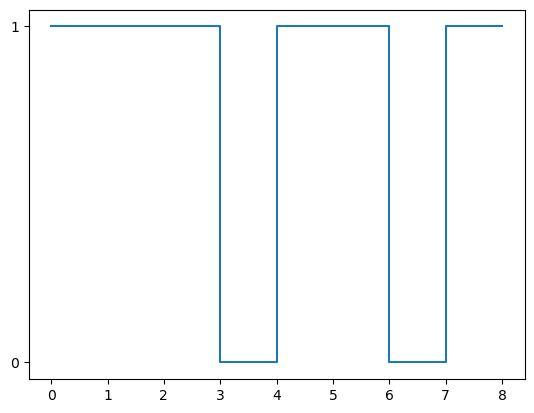

In [113]:
import numpy as np
import matplotlib.pyplot as plt

data = [1, 0, 0, 1, 1, 0, 1, 0]
xs = np.repeat(range(len(data)), 2)
ys = np.repeat(data, 2)
xs = xs[1:]
ys = ys[:-1]
xs = np.append(xs,xs[-1] + 1)
ys = np.append(ys, ys[-1])

#ys = np.array([1,0,1,1,1,1,0,1,1])
ys = np.array([1,1,1,1,0,1,1,0,1])
xs = np.array([0,1,2,3,4,5,6,7,8])



plt.yticks([0,1])
#plt.step(din1_x, din1_y)
#plt.scatter(din1_x[:15], din1_y[:15])
#plt.step(din1_x[:5], din1_y[:5])
plt.step(xs, ys)
